In [1]:
!pip install torch torchvision numpy matplotlib psutil seaborn 

In [2]:
import torch
import torchvision.models as models
import numpy as np

In [3]:
resnet18 = models.resnet18(pretrained=False)
params = list(resnet18.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
raw_size = sum(p.numel() for p in params) * 4  # Assuming 32-bit floats (4 bytes each)
print(f"Raw model size: {raw_size / (1024 ** 2):.2f} MB")

Raw model size: 44.59 MB


In [5]:
from openfhe import *

def setup_ckks_context():
    parameters = CCParamsCKKSRNS()
    
    parameters.SetSecretKeyDist(SecretKeyDist.UNIFORM_TERNARY)
    parameters.SetSecurityLevel(SecurityLevel.HEStd_NotSet)
    parameters.SetRingDim(1 << 12)
    
    if get_native_int() == 128:
        rescale_tech = ScalingTechnique.FIXEDAUTO
        dcrt_bits = 78
        first_mod = 89
    else:
        rescale_tech = ScalingTechnique.FLEXIBLEAUTO
        dcrt_bits = 59
        first_mod = 60
    
    parameters.SetScalingModSize(dcrt_bits)
    parameters.SetScalingTechnique(rescale_tech)
    parameters.SetFirstModSize(first_mod)
    parameters.SetMultiplicativeDepth(4)
    
    cc = GenCryptoContext(parameters)
    
    cc.Enable(PKESchemeFeature.PKE)
    cc.Enable(PKESchemeFeature.KEYSWITCH)
    cc.Enable(PKESchemeFeature.LEVELEDSHE)
    cc.Enable(PKESchemeFeature.MULTIPARTY)
    
    return cc

class MultiPartyHE:
    def __init__(self):
        self.cc = setup_ckks_context()
        self.keyPairs = []
        self.joint_public_key = None
        self.ring_dim = self.cc.GetRingDimension()
        self.num_slots = int(self.ring_dim / 2)
    
    def generate_keys(self, num_parties=2):
        # Generate key pair for first party
        keyPair1 = self.cc.KeyGen()
        self.keyPairs.append(keyPair1)
        
        # Generate key pairs for other parties
        for i in range(1, num_parties):
            # Use the correct signature: MultipartyKeyGen(publicKey, makeSparse=False, fresh=False)
            keyPair = self.cc.MultipartyKeyGen(self.keyPairs[0].publicKey, False, True)
            self.keyPairs.append(keyPair)
        
        # Generate joint public key using private keys
        private_keys = [kp.secretKey for kp in self.keyPairs]
        self.joint_key_pair = self.cc.MultipartyKeyGen(private_keys)
        self.joint_public_key = self.joint_key_pair.publicKey
        
        # Generate evaluation keys
        self.cc.EvalMultKeyGen(self.joint_key_pair.secretKey)
        
        return self.joint_public_key
    
    def encrypt(self, data, level=1):
        if not isinstance(data, list):
            data = [float(data)]
        plaintext = self.cc.MakeCKKSPackedPlaintext(data, 1, level)
        plaintext.SetLength(len(data))
        return self.cc.Encrypt(self.joint_public_key, plaintext)
    
    def decrypt(self, ciphertext):
        # Use the joint secret key for decryption
        result = self.cc.Decrypt(ciphertext, self.joint_key_pair.secretKey)
        return result
    
    def add(self, cipher1, cipher2):
        return self.cc.EvalAdd(cipher1, cipher2)
    
    def multiply(self, cipher1, cipher2):
        return self.cc.EvalMult(cipher1, cipher2)

In [6]:
def encrypt_parameters(params, encrypt_ratio=1.0):
    """
    Encrypt a given ratio of the model's parameters.
    :param params: List of PyTorch tensors (model parameters).
    :param encrypt_ratio: Ratio of parameters to encrypt (0.0 to 1.0).
    :return: Encrypted parameters and their estimated size in bytes.
    """
    encrypted_params = []
    total_params = len(params)
    num_to_encrypt = int(total_params * encrypt_ratio)
    max_size = mhe.num_slots  # Maximum size allowed by CKKS (ringDim / 2)

    for i, param in enumerate(params):
        param_data = param.detach().cpu().numpy().flatten().tolist()
        if i < num_to_encrypt:
            # Encrypt the parameter in chunks if it exceeds max_size
            encrypted_chunks = []
            for j in range(0, len(param_data), max_size):
                chunk = param_data[j:j + max_size]
                encrypted_chunk = mhe.encrypt(chunk)
                encrypted_chunks.append(encrypted_chunk)
            encrypted_params.append(encrypted_chunks)
        else:
            # Keep the parameter as is
            encrypted_params.append(param_data)
    
    # Estimate encrypted model size
    # Each ciphertext is approximately proportional to ringDim and dcrt_bits
    dcrt_bits = 59  # Use the value set in `setup_ckks_context`
    ciphertext_size = mhe.ring_dim * dcrt_bits * 2  # Approximation
    encrypted_size = sum(ciphertext_size for param in encrypted_params[:num_to_encrypt] for chunk in param)
    return encrypted_params, encrypted_size

In [7]:
# Fully encrypt the model
_, fully_encrypted_size = encrypt_parameters(params, encrypt_ratio=1.0)

# Partially encrypt 12% of the model
_, partially_encrypted_size = encrypt_parameters(params, encrypt_ratio=0.12)

# Display results
print(f"Raw model size: {raw_size / (1024 ** 2):.2f} MB")
print(f"Fully encrypted model size: {fully_encrypted_size / (1024 ** 2):.2f} MB")
print(f"Partially encrypted model size (12%): {partially_encrypted_size / (1024 ** 2):.2f} MB")

NameError: name 'mhe' is not defined

In [ ]:
# new woth power

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Raw model size: 44.59 MB
Fully encrypted model size (encrypted parts only): 2647.62 MB
Partially encrypted model size (12% encrypted + 88% raw) - Total: 65.02 MB
  - Encrypted part size (12% of parameters): 20.74 MB
  - Raw part size (88% of parameters): 44.27 MB
Full encryption time: 14.30 seconds
Partial encryption time (12%): 0.35 seconds

Computation and Communication Analysis for Partial Encryption (12%):
Computation:
  - 12% of model parameters (encrypted part) will require Homomorphic Encryption operations (slower).
  - 88% of model parameters (raw part) will use standard, unencrypted operations (faster).
  - Overall computation time will be dominated by the HE operations on the 12% encrypted parameters, but will be significantly faster than fully HE inference if the 88% raw parameters contribute significantly to the computation.

Communication:
  - Encrypted part (12% parameters): Size is increased due to encryption overhead (from raw size to ~20.74 MB).
  - Raw part (88% param

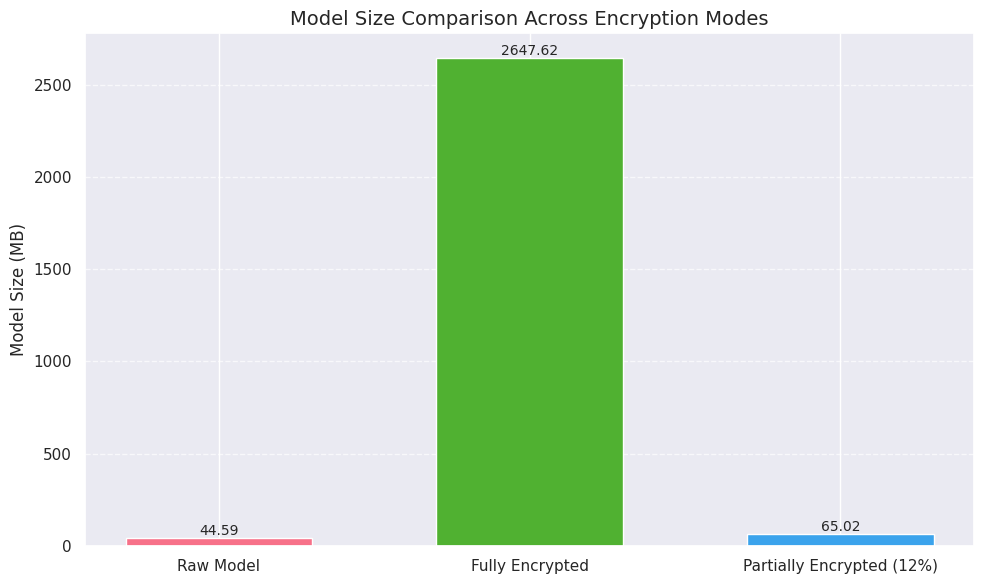

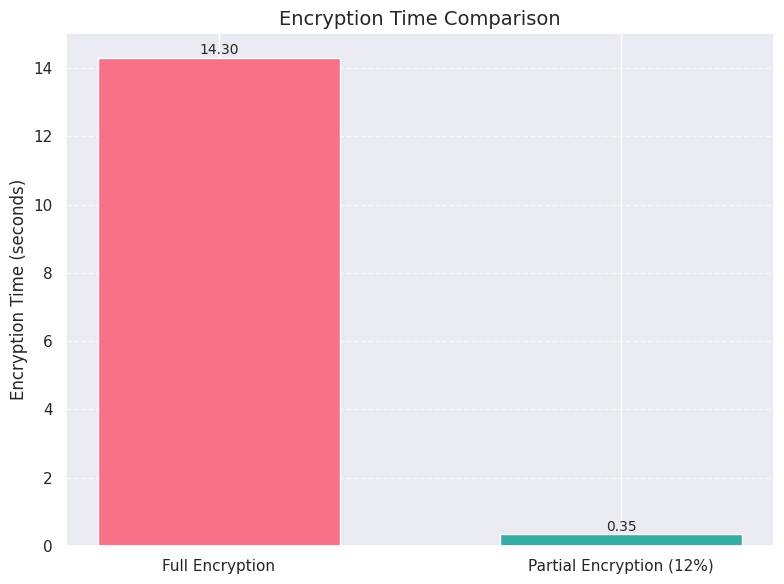

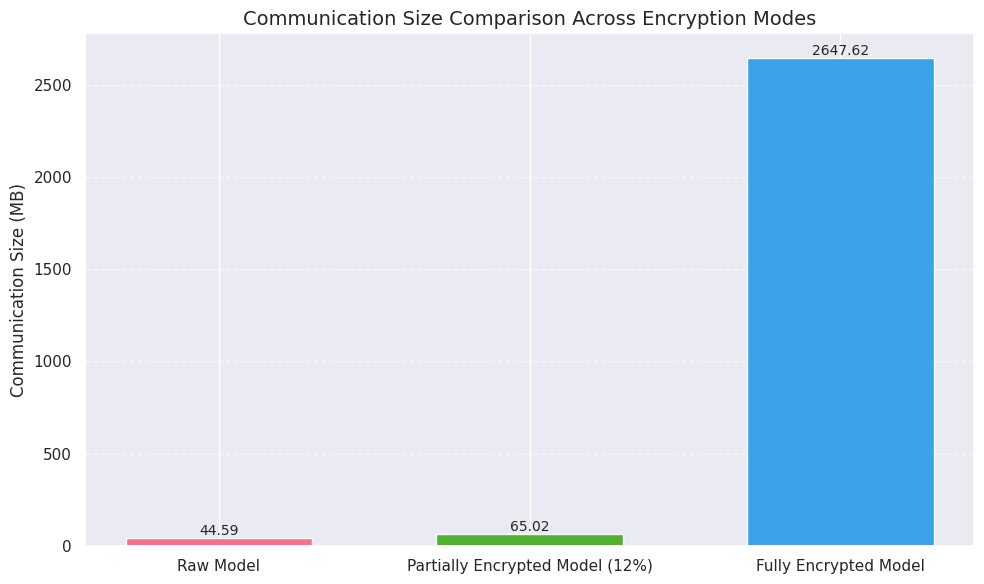

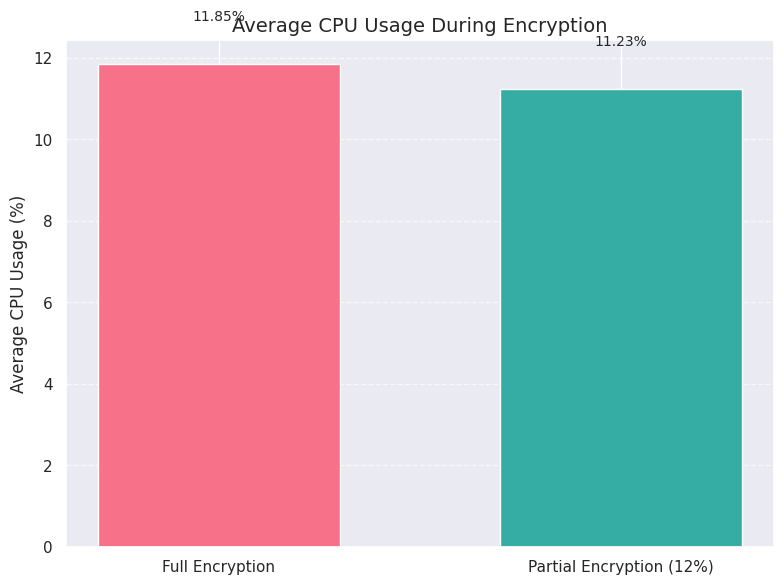

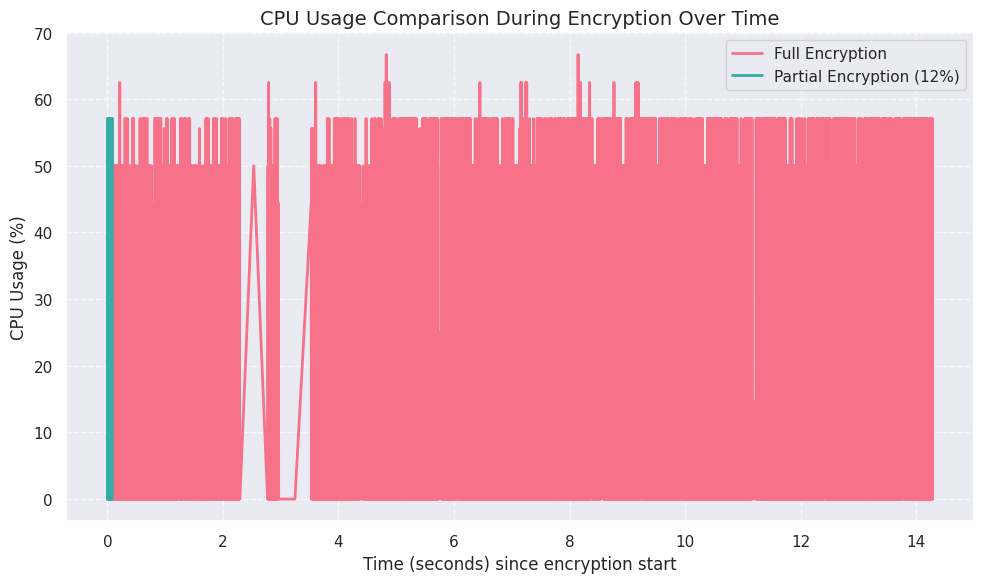


Plots saved as: combined_model_size_comparison_beautiful.png, combined_encryption_time_comparison_beautiful.png, combined_communication_size_comparison_beautiful.png, combined_avg_cpu_usage_comparison_beautiful.png, combined_cpu_usage_timeseries_comparison_beautiful.png

**CPU Usage is a proxy for power consumption. For accurate power measurements, hardware power meters are required.**


In [8]:
import torch
import torchvision.models as models
import numpy as np
import time
from openfhe import *
import matplotlib.pyplot as plt
import psutil
import seaborn as sns  # Import seaborn for better aesthetics

# Set seaborn style for more appealing plots (optional, but recommended)
sns.set_theme()

resnet18 = models.resnet18(pretrained=False)
params = list(resnet18.parameters())
raw_size = sum(p.numel() for p in params) * 4


def setup_ckks_context():
    parameters = CCParamsCKKSRNS()
    parameters.SetSecretKeyDist(SecretKeyDist.UNIFORM_TERNARY)
    parameters.SetSecurityLevel(SecurityLevel.HEStd_NotSet)
    parameters.SetRingDim(1 << 12)

    if get_native_int() == 128:
        rescale_tech = ScalingTechnique.FIXEDAUTO
        dcrt_bits = 78
        first_mod = 89
    else:
        rescale_tech = ScalingTechnique.FLEXIBLEAUTO
        dcrt_bits = 59
        first_mod = 60

    parameters.SetScalingModSize(dcrt_bits)
    parameters.SetScalingTechnique(rescale_tech)
    parameters.SetFirstModSize(first_mod)
    parameters.SetMultiplicativeDepth(4)

    cc = GenCryptoContext(parameters)
    cc.Enable(PKESchemeFeature.PKE)
    cc.Enable(PKESchemeFeature.KEYSWITCH)
    cc.Enable(PKESchemeFeature.LEVELEDSHE)
    cc.Enable(PKESchemeFeature.MULTIPARTY)
    return cc


class MultiPartyHE:
    def __init__(self):
        self.cc = setup_ckks_context()
        self.keyPairs = []
        self.joint_public_key = None
        self.ring_dim = self.cc.GetRingDimension()
        self.num_slots = int(self.ring_dim / 2)

    def generate_keys(self, num_parties=2):
        keyPair1 = self.cc.KeyGen()
        self.keyPairs.append(keyPair1)
        for i in range(1, num_parties):
            keyPair = self.cc.MultipartyKeyGen(self.keyPairs[0].publicKey, False, True)
            self.keyPairs.append(keyPair)
        private_keys = [kp.secretKey for kp in self.keyPairs]
        self.joint_key_pair = self.cc.MultipartyKeyGen(private_keys)
        self.joint_public_key = self.joint_key_pair.publicKey
        self.cc.EvalMultKeyGen(self.joint_key_pair.secretKey)
        return self.joint_public_key

    def encrypt(self, data, level=1):
        if not isinstance(data, list):
            data = [float(data)]
        plaintext = self.cc.MakeCKKSPackedPlaintext(data, 1, level)
        plaintext.SetLength(len(data))
        return self.cc.Encrypt(self.joint_public_key, plaintext)

    def decrypt(self, ciphertext):
        result = self.cc.Decrypt(ciphertext, self.joint_key_pair.secretKey)
        return result

    def add(self, cipher1, cipher2):
        return self.cc.EvalAdd(cipher1, cipher2)

    def multiply(self, cipher1, cipher2):
        return self.cc.EvalMult(cipher1, cipher2)


def encrypt_parameters(params, encrypt_ratio=1.0, cpu_usage_list=None):
    encrypted_params = []
    total_params = len(params)
    num_to_encrypt = int(total_params * encrypt_ratio)
    max_size = mhe.num_slots
    encrypted_part_size = 0
    raw_part_size = 0
    for i, param in enumerate(params):
        param_data = param.detach().cpu().numpy().flatten().tolist()
        param_raw_size = param.numel() * 4

        if i < num_to_encrypt:
            encrypted_chunks = []
            for j in range(0, len(param_data), max_size):
                chunk = param_data[j : j + max_size]
                start_chunk_time = time.time()
                encrypted_chunk = mhe.encrypt(chunk)
                end_chunk_time = time.time()
                if cpu_usage_list is not None:
                    cpu_usage_list.append(
                        {
                            "time": (start_chunk_time + end_chunk_time) / 2,
                            "usage": psutil.cpu_percent(),
                        }
                    )

                encrypted_chunks.append(encrypted_chunk)
            encrypted_params.append(encrypted_chunks)

            dcrt_bits = 59
            ciphertext_size_approx = mhe.ring_dim * dcrt_bits * 2
            encrypted_part_size += len(encrypted_chunks) * ciphertext_size_approx
        else:
            encrypted_params.append(param_data)
            raw_part_size += param_raw_size

    dcrt_bits = 59
    ciphertext_size = mhe.ring_dim * dcrt_bits * 2
    encrypted_size = sum(
        ciphertext_size
        for param in encrypted_params[:num_to_encrypt]
        for chunk in param
    )

    return encrypted_params, encrypted_size, encrypted_part_size, raw_part_size


mhe = MultiPartyHE()
joint_public_key = mhe.generate_keys(num_parties=2)

cpu_usage_full_encryption = []
cpu_usage_partial_encryption = []

start_time_full = time.time()
_, fully_encrypted_size_only_enc, _, _ = encrypt_parameters(
    params, encrypt_ratio=1.0, cpu_usage_list=cpu_usage_full_encryption
)
end_time_full = time.time()
full_encryption_time = end_time_full - start_time_full

start_time_partial = time.time()
(
    _,
    partially_encrypted_size_only_enc,
    encrypted_part_size_partial,
    raw_part_size_partial,
) = encrypt_parameters(
    params, encrypt_ratio=0.12, cpu_usage_list=cpu_usage_partial_encryption
)
end_time_partial = time.time()
partial_encryption_time = end_time_partial - start_time_partial

total_partially_encrypted_model_size = (
    encrypted_part_size_partial + raw_part_size_partial
)

raw_size_mb = raw_size / (1024**2)
fully_encrypted_size_only_enc_mb = fully_encrypted_size_only_enc / (1024**2)
partially_encrypted_total_mb = total_partially_encrypted_model_size / (1024**2)
encrypted_part_size_partial_mb = encrypted_part_size_partial / (1024**2)
raw_part_size_partial_mb = raw_part_size_partial / (1024**2)

print(f"Raw model size: {raw_size_mb:.2f} MB")
print(
    f"Fully encrypted model size (encrypted parts only): {fully_encrypted_size_only_enc_mb:.2f} MB"
)
print(
    f"Partially encrypted model size (12% encrypted + 88% raw) - Total: {partially_encrypted_total_mb:.2f} MB"
)
print(
    f"  - Encrypted part size (12% of parameters): {encrypted_part_size_partial_mb:.2f} MB"
)
print(f"  - Raw part size (88% of parameters): {raw_part_size_partial_mb:.2f} MB")
print(f"Full encryption time: {full_encryption_time:.2f} seconds")
print(f"Partial encryption time (12%): {partial_encryption_time:.2f} seconds")

print("\nComputation and Communication Analysis for Partial Encryption (12%):")
print("Computation:")
print(
    "  - 12% of model parameters (encrypted part) will require Homomorphic Encryption operations (slower)."
)
print(
    "  - 88% of model parameters (raw part) will use standard, unencrypted operations (faster)."
)
print(
    "  - Overall computation time will be dominated by the HE operations on the 12% encrypted parameters, but will be significantly faster than fully HE inference if the 88% raw parameters contribute significantly to the computation."
)

print("\nCommunication:")
print(
    "  - Encrypted part (12% parameters): Size is increased due to encryption overhead (from raw size to ~{:.2f} MB).".format(
        encrypted_part_size_partial_mb
    )
)
print(
    "  - Raw part (88% parameters): Size remains the same as the corresponding raw model part (~{:.2f} MB).".format(
        raw_part_size_partial_mb
    )
)
print(
    "  - Total communication size for the partially encrypted model is the sum of encrypted and raw parts (~{:.2f} MB).".format(
        partially_encrypted_total_mb
    )
)
print(
    "  - Compared to sending the fully raw model (~{:.2f} MB), partially encrypted model increases communication size. Compared to fully encrypted model (~{:.2f} MB), partially encrypted model reduces communication size.".format(
        raw_size_mb, fully_encrypted_size_only_enc_mb
    )
)

# --- Combined Plotting Section ---

# 1. Combined Model Size Comparison (Bar Plot) - Enhanced Aesthetics
model_types_size = ["Raw Model", "Fully Encrypted", "Partially Encrypted (12%)"]
model_sizes = [
    raw_size_mb,
    fully_encrypted_size_only_enc_mb,
    partially_encrypted_total_mb,
]
plt.figure(figsize=(10, 6))
bars = plt.bar(
    model_types_size, model_sizes, color=sns.color_palette("husl", 3), width=0.6
)  # Seaborn color palette, wider bars
plt.ylabel("Model Size (MB)", fontsize=12)  # Larger font size
plt.title(
    "Model Size Comparison Across Encryption Modes", fontsize=14
)  # More descriptive title, larger font size
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines for y-axis
for bar in bars:  # Add value labels on top of bars
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        f"{yval:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.savefig("combined_model_size_comparison_beautiful.png")  # New filename
plt.show()

# 2. Combined Encryption Time Comparison (Bar Plot) - Enhanced Aesthetics
encryption_types_combined = ["Full Encryption", "Partial Encryption (12%)"]
encryption_times_combined = [full_encryption_time, partial_encryption_time]
plt.figure(figsize=(8, 6))
bars = plt.bar(
    encryption_types_combined,
    encryption_times_combined,
    color=sns.color_palette("husl", 2),
    width=0.6,
)  # Seaborn color palette, wider bars
plt.ylabel("Encryption Time (seconds)", fontsize=12)  # Larger font size
plt.title("Encryption Time Comparison", fontsize=14)  # Larger font size
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        f"{yval:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.savefig("combined_encryption_time_comparison_beautiful.png")  # New filename
plt.show()

# 3. Combined Communication Size Comparison (Bar Plot) - Enhanced Aesthetics
model_types_comm_combined = [
    "Raw Model",
    "Partially Encrypted Model (12%)",

    "Fully Encrypted Model",
]
communication_sizes_combined = [
    raw_size_mb,
    partially_encrypted_total_mb,
    fully_encrypted_size_only_enc_mb,

]
plt.figure(figsize=(10, 6))
bars = plt.bar(
    model_types_comm_combined,
    communication_sizes_combined,
    color=sns.color_palette("husl", 3),
    width=0.6,
)  # Seaborn color palette, wider bars
plt.ylabel("Communication Size (MB)", fontsize=12)  # Larger font size
plt.title(
    "Communication Size Comparison Across Encryption Modes", fontsize=14
)  # More descriptive title, larger font size
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        f"{yval:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.savefig("combined_communication_size_comparison_beautiful.png")  # New filename
plt.show()

# 4. Combined CPU Usage Comparison (Bar Plot - Average Usage) - Enhanced Aesthetics
if cpu_usage_full_encryption and cpu_usage_partial_encryption:
    avg_usage_full = (
        np.mean([item["usage"] for item in cpu_usage_full_encryption])
        if cpu_usage_full_encryption
        else 0
    )
    avg_usage_partial = (
        np.mean([item["usage"] for item in cpu_usage_partial_encryption])
        if cpu_usage_partial_encryption
        else 0
    )

    cpu_types = ["Full Encryption", "Partial Encryption (12%)"]
    avg_cpu_usages = [avg_usage_full, avg_usage_partial]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        cpu_types, avg_cpu_usages, color=sns.color_palette("husl", 2), width=0.6
    )  # Seaborn color palette, wider bars
    plt.ylabel("Average CPU Usage (%)", fontsize=12)  # Larger font size
    plt.title("Average CPU Usage During Encryption", fontsize=14)  # Larger font size
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 1,
            f"{yval:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10,
        )  # Added percentage sign
    plt.tight_layout()
    plt.savefig("combined_avg_cpu_usage_comparison_beautiful.png")  # New filename
    plt.show()
else:
    print(
        "\nNo CPU usage data collected for one or both encryption types. Combined CPU plot not generated."
    )

# 5. Combined CPU Usage during Encryption (Two Lines in One Plot - Legend Position Adjusted & Aesthetics) - Enhanced Aesthetics
if cpu_usage_full_encryption and cpu_usage_partial_encryption:
    time_full_cpu = [
        item["time"] - start_time_full for item in cpu_usage_full_encryption
    ]
    usage_full_cpu = [item["usage"] for item in cpu_usage_full_encryption]
    time_partial_cpu = [
        item["time"] - start_time_partial for item in cpu_usage_partial_encryption
    ]
    usage_partial_cpu = [item["usage"] for item in cpu_usage_partial_encryption]

    plt.figure(figsize=(10, 6))
    plt.plot(
        time_full_cpu,
        usage_full_cpu,
        label="Full Encryption",
        color=sns.color_palette("husl", 2)[0],
        linewidth=2,
    )  # Seaborn color palette, thicker lines
    plt.plot(
        time_partial_cpu,
        usage_partial_cpu,
        label="Partial Encryption (12%)",
        color=sns.color_palette("husl", 2)[1],
        linewidth=2,
    )  # Seaborn color palette, thicker lines
    plt.xlabel("Time (seconds) since encryption start", fontsize=12)  # Larger font size
    plt.ylabel("CPU Usage (%)", fontsize=12)  # Larger font size
    plt.title(
        "CPU Usage Comparison During Encryption Over Time", fontsize=14
    )  # More descriptive title, larger font size
    plt.legend(
        loc="upper right", fontsize=11
    )  # Legend position set to upper right, larger font size
    plt.grid(True, linestyle="--", alpha=0.7)  # Grid lines
    plt.tight_layout()
    plt.savefig(
        "combined_cpu_usage_timeseries_comparison_beautiful.png"
    )  # New filename
    plt.show()
else:
    print(
        "\nNo CPU usage data collected for one or both encryption types (psutil might not be available). Timeseries Combined CPU plot not generated."
    )

print(
    "\nPlots saved as: combined_model_size_comparison_beautiful.png, combined_encryption_time_comparison_beautiful.png, combined_communication_size_comparison_beautiful.png, combined_avg_cpu_usage_comparison_beautiful.png, combined_cpu_usage_timeseries_comparison_beautiful.png"
)  # Updated saved plot filenames with "beautiful" suffix
print(
    "\n**CPU Usage is a proxy for power consumption. For accurate power measurements, hardware power meters are required.**"
)
